In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                    0 |
| N/A   45C    P0    68W / 275W |      3MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   2  NVIDIA A100-SXM...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   46C    P0    67W / 275W |   1919MiB / 81251MiB |     23%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   3  NVIDIA DGX Display  On   | 00000000:C1:00.0 Off |                  N/A |
| 34%   43C    P8    N/A /  50W |    487MiB /  3909MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   4  NVIDIA A100-SXM...  On   | 000000

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[22:27:31.198] INFO   CaloQVAE                                          Willkommen!
[22:27:31.199] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

2023-07-13 22:27:36,027 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[22:27:36.027] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/home/javier/miniconda3/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[22:27:40.593] INFO   data.dataManager                                  Loading Data
[22:27:44.403] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fdb0b8b71f0>: 96184 events, 752 batches
[22:27:44.404] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fdb0b82d400>: 12023 events, 12 batches
[22:27:44.404] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fdb0afc4e80>: 12023 events, 12 batches
[22:27:46.200] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNN
2023-07-13 22:27:46

Initializing NetworkV3
Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[22:27:49.510] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 533])
[22:27:49.511] INFO   wandb                                             Watching
/home/javier/miniconda3/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[22:27:49.905] INFO   engine.engineAtlas                                Setting up engine Atlas.
[22:27:49.905] INFO   engine.engineCaloV3                               Setting up engine Calo.
[22:27:49.906] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[22:27:56.441] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fdaad7dffa0>: 96184 events, 752 batches
[22:27:56.442] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fdaad7dffd0>: 12023 events, 12 batches
[22:27:56.443] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fdaad7dff10>: 12023 events, 12 batches


In [10]:
###LOAD MODEL

In [11]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [12]:
#Pions cond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-05/12-27-11/wandb/run-20230705_122715-uxyvraes/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth'
#Pions Noncond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-06-30/06-51-53/wandb/run-20230630_065158-qx3cmkt0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-07/17-09-08/wandb/run-20230707_170909-vsslbz0h/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"


#Photons Noncond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-01/16-26-45/wandb/run-20230701_162650-eap4avzf/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
#Photons cond dec
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-07/08-39-58/wandb/run-20230707_084003-a3wr6q10/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
#Photons w/ classifier
# run_path = '/home/javier/Projects/CaloQVAE/outputs/2023-07-08/23-57-14/wandb/run-20230708_235715-u7yk2qyo/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
# run_path = '/home/javier/Projects/CaloQVAE/outputs/2023-07-09/13-28-53/wandb/run-20230709_132854-ndjguffk/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'


# photonEn0
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/19-17-34/wandb/run-20230711_191735-ps7le1q8/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# photonEn7
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/19-08-43/wandb/run-20230711_190844-hyruxtix/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# pionEn0
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/18-35-00/wandb/run-20230711_183501-jeg84356/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# pionEn7
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-11/18-34-47/wandb/run-20230711_183448-s2yyt3me/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

#pion1 EncUCNN summer-energy
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-10/16-43-00/wandb/run-20230710_164301-wsjt5x1k/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

#pion1 avid-dream
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-07-10/16-43-00/wandb/run-20230710_164301-wsjt5x1k/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder


RuntimeError: Error(s) in loading state_dict for EncoderCNN:
	Missing key(s) in state_dict: "_networks.0.1.1.bias", "_networks.0.1.1.running_mean", "_networks.0.1.1.running_var", "_networks.0.1.3.weight", "_networks.0.1.3.bias", "_networks.0.1.5.weight", "_networks.0.1.6.weight", "_networks.0.1.6.bias", "_networks.0.1.6.running_mean", "_networks.0.1.6.running_var", "_networks.0.1.7.weight", "_networks.0.1.7.bias", "_networks.0.1.8.weight", "_networks.0.1.8.bias", "_networks.0.1.8.running_mean", "_networks.0.1.8.running_var", "_networks.0.1.9.weight", "_networks.0.1.10.weight", "_networks.0.1.10.bias", "_networks.0.1.11.weight", "_networks.0.1.11.bias", "_networks.0.1.11.running_mean", "_networks.0.1.11.running_var", "_networks.0.1.12.weight", "_networks.0.1.13.weight", "_networks.0.1.13.bias", "_networks.0.1.15.weight", "_networks.0.1.15.bias", "_networks.0.1.15.running_mean", "_networks.0.1.15.running_var", "_networks.0.1.16.weight", "_networks.0.1.17.weight", "_networks.0.1.17.bias", "sequential.0.weight", "sequential.0.bias", "sequential2.0.weight", "sequential2.0.bias", "sequential2.1.weight", "sequential2.1.bias", "sequential2.1.running_mean", "sequential2.1.running_var", "sequential2.2.weight", "sequential2.3.weight", "sequential2.3.bias", "sequential2.5.weight", "sequential2.6.weight", "sequential2.6.bias", "sequential2.6.running_mean", "sequential2.6.running_var", "sequential2.7.weight", "sequential2.7.bias", "sequential2.8.weight", "sequential2.8.bias", "sequential2.8.running_mean", "sequential2.8.running_var", "sequential2.9.weight", "sequential2.10.weight", "sequential2.10.bias", "sequential2.11.weight", "sequential2.11.bias", "sequential2.11.running_mean", "sequential2.11.running_var", "sequential2.12.weight", "sequential2.13.weight", "sequential2.13.bias", "sequential2.15.weight", "sequential2.15.bias", "sequential2.15.running_mean", "sequential2.15.running_var", "sequential2.16.weight", "sequential2.17.weight", "sequential2.17.bias". 
	Unexpected key(s) in state_dict: "seq1.0.weight", "seq1.0.bias", "seq1.2.weight", "seq1.2.bias", "seq1.3.weight", "seq1.3.bias", "seq1.3.running_mean", "seq1.3.running_var", "seq1.3.num_batches_tracked", "seq1.4.weight", "seq2.0.weight", "seq2.0.bias", "seq2.1.weight", "seq2.2.weight", "seq2.2.bias", "seq2.2.running_mean", "seq2.2.running_var", "seq2.2.num_batches_tracked", "seq3.0.weight", "seq3.0.bias", "seq3.1.weight", "seq3.1.bias", "seq3.1.running_mean", "seq3.1.running_var", "seq3.1.num_batches_tracked", "seq3.2.weight", "seq4.0.weight", "seq4.0.bias", "seq4.2.weight", "seq4.3.weight", "seq4.3.bias", "seq4.3.running_mean", "seq4.3.running_var", "seq4.3.num_batches_tracked", "seq4.4.weight", "seq4.4.bias", "seq4.5.weight", "seq4.5.bias", "seq4.5.running_mean", "seq4.5.running_var", "seq4.5.num_batches_tracked", "seq4.6.weight", "seq4.7.weight", "seq4.7.bias", "seq4.8.weight", "seq4.8.bias", "seq4.8.running_mean", "seq4.8.running_var", "seq4.8.num_batches_tracked", "seq4.9.weight", "seq4.10.weight", "seq4.10.bias", "seq4.12.weight", "seq4.12.bias", "seq4.12.running_mean", "seq4.12.running_var", "seq4.12.num_batches_tracked", "seq4.13.weight", "seq4.14.weight", "seq4.14.bias", "_networks.0.0.2.weight", "_networks.0.0.2.bias", "_networks.0.0.3.weight", "_networks.0.0.3.bias", "_networks.0.0.3.running_mean", "_networks.0.0.3.running_var", "_networks.0.0.3.num_batches_tracked", "_networks.0.0.4.weight", "_networks.0.1.2.bias", "_networks.0.1.2.running_mean", "_networks.0.1.2.running_var", "_networks.0.1.2.num_batches_tracked". 
	size mismatch for _networks.0.1.0.weight: copying a param with shape torch.Size([32, 17, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 2, 3, 3]).
	size mismatch for _networks.0.1.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for _networks.0.1.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for _networks.0.1.2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

In [136]:
# model.decoder

In [174]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [175]:
# in_data.shape
# xx[0][0].shape

torch.Size([1024, 368])


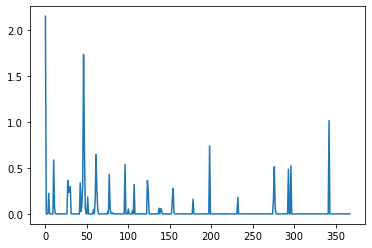

In [176]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[2,:])

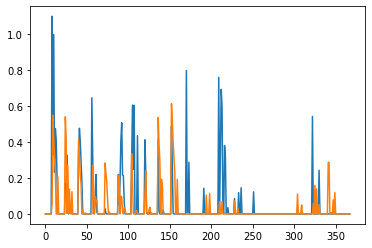

In [177]:
with torch.no_grad():
    fwd_output = engine.model((in_data, true_energy), True)
idx = 20
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])

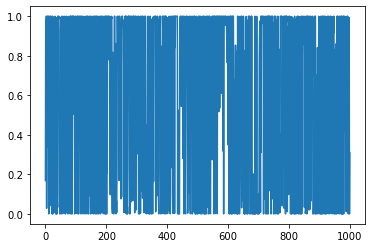

In [141]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

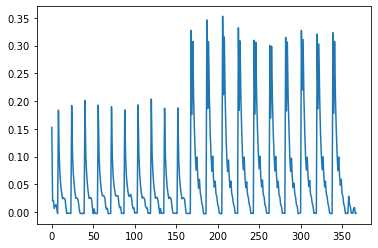

In [142]:
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())

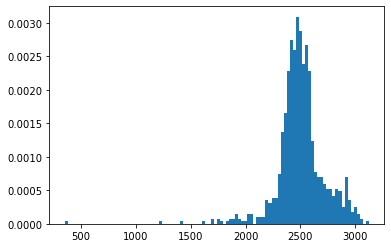

In [143]:
plt.hist(fwd_output.output_hits.sum(dim=1).detach().cpu().numpy(), bins=100, density=True)
# plt.hist(output_activations.sum(dim=1).detach().cpu().numpy(), bins=100, density=True)
# plt.plot(fwd_output.output_hits[idx,:].detach().cpu().numpy())
plt.show()

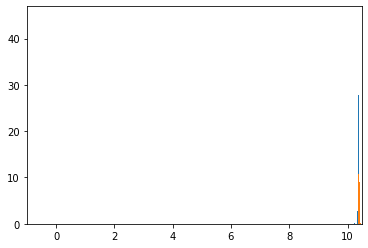

In [144]:
xhat = (output_activations.detach().exp() - 1)*0.04*true_energy
plt.hist(np.log(xx[0][0].sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
plt.hist(np.log(xhat.sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
plt.xlim(left=-1)
plt.show()

In [145]:
# model.loss(in_data, fwd_output ,true_energy)
val_loader.__len__()

9

In [178]:
en_labels = []
xtarget_samples = []
xrecon_samples = []
xitarget_samples = []
xirecon_samples = []
labelstarget_samples = []
labelsrecon_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    xVec = (fwd_output.output_activations.detach().exp() - 1)*0.04*true_energy
    
    xirecon_samples.append(fwd_output.output_activations.detach().cpu())
    xrecon_samples.append( xVec.detach().cpu() )
    labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    
    xitarget_samples.append(in_data.detach().cpu())
    xtarget_samples.append( xx[0][0].detach().cpu() )
    labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
    en_labels.append(true_energy.detach().cpu())
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
xitarget_samples = torch.cat(xitarget_samples, dim=0)  
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xirecon_samples = torch.cat(xirecon_samples, dim=0) 
labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
en_labels = torch.cat(en_labels, dim=0)

lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
l = torch.argmax(labelstarget_samples, dim=1).numpy()

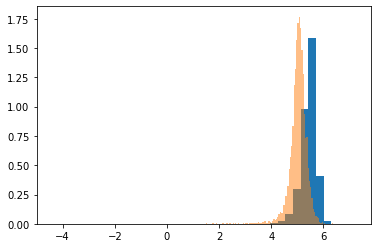

In [179]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True)
plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
plt.xlim(left=-5)
plt.show()

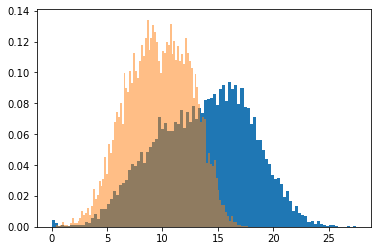

In [180]:
plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=100, density=True)
plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.show()

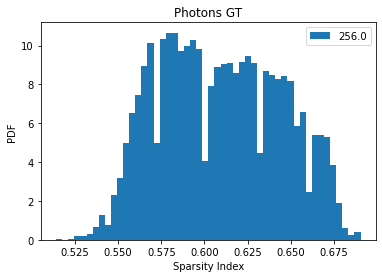

In [181]:
#Sparsity
for enIdx in en_labels.unique().numpy():
    idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
    xtargetTmp = xtarget_samples[idxBool,:]
    xreconTmp = xrecon_samples[idxBool, :]
    plt.hist(((xtargetTmp == 0).sum(dim=1)/533).numpy(), bins=50, density=True)
#     plt.hist(((xreconTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True, alpha=0.9)
plt.legend(list(en_labels.unique().numpy()))
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.title("Photons GT")
plt.show()

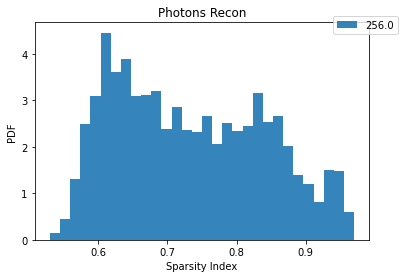

In [182]:
#Sparsity
for enIdx in en_labels.unique().numpy():
    idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
    xtargetTmp = xtarget_samples[idxBool,:]
    xreconTmp = xrecon_samples[idxBool, :]
    # plt.hist(((xtargetTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True)
    plt.hist(((xreconTmp == 0).sum(dim=1)/368).numpy(), bins=30, density=True, alpha=0.9)
plt.legend(list(en_labels.unique().numpy()), bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.title("Photons Recon")
plt.show()

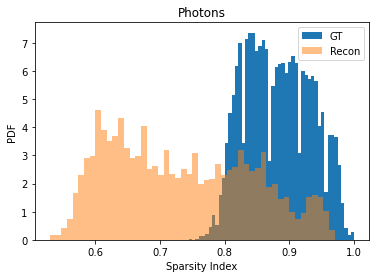

In [183]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/368).numpy(), bins=50, density=True)
plt.hist(((xrecon_samples == 0).sum(dim=1)/368).numpy(), bins=50, density=True, alpha=0.5)
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.legend(["GT", "Recon"])
plt.title("Photons")
plt.show()

In [30]:
# plt.plot(l[:10])
# plt.plot(lhat[:10])
np.sum(np.sign(np.abs(l - lhat)))/len(l)

0.0009090909090909091

In [33]:
xihat_samples.shape

torch.Size([71680, 533])

In [61]:

lhatSamp.shape
labelshat_samples.shape
5*15*1024
xhat_samples.shape

torch.Size([76800, 368])

In [41]:
# model.generate_samples(num_samples=1024, true_energy=0)

In [42]:
# sample_data

In [184]:
xhat_samples = []
xihat_samples = []
# labelshat_samples = []
with torch.no_grad():
    for en in range(0,1):
        data_sampled = []
        for i in range(5):
            sample_energies, sample_data = model.generate_samples(num_samples=1024, true_energy=en)
            data_sampled.append(sample_data.detach().cpu())
        data_sampled = torch.cat(data_sampled, dim=0)
        xhat_samples.append((data_sampled.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),en))
        xihat_samples.append(data_sampled)
        # labelshat_samples.append(fwd_output.labels.detach().cpu())
xhat_samples = torch.cat(xhat_samples, dim=0)
xihat_samples = torch.cat(xihat_samples, dim=0)
# labelshat_samples = torch.cat(labelshat_samples, dim=0)

# lhatSamp = torch.argmax(nn.Sigmoid()(labelshat_samples), dim=1).numpy()

In [28]:
sam = []
for i in range(1):
    sample_energies, sample_data = model.generate_samples(num_samples=1000, true_energy=14)
    sam.append(sample_data.detach().cpu())
sam = torch.cat(sam, dim=0)

NameError: name 'sample_data_test' is not defined

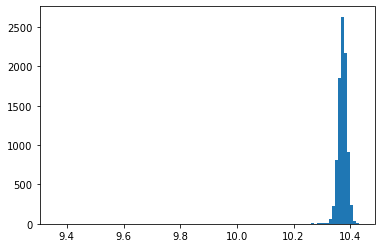

In [58]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=False)
# plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
# plt.hist(np.log(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.7)

sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),7)
plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("Log of energy per event")
plt.ylabel("PDF")
plt.legend(["GT", "Sample"])
plt.title("Photons")
plt.show()

In [25]:
# xhat = (sample_data.detach().exp() - 1)*0.04*256*np.power(2,1)
# # plt.hist(xhat.sum(dim=1).cpu().numpy(), bins=100, density=True)
# plt.hist(np.log(xhat.sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
# plt.show()

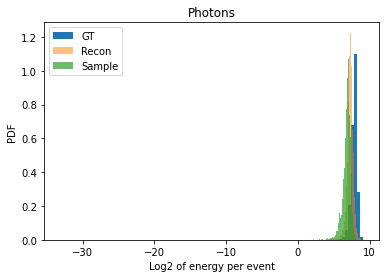

In [185]:
plt.hist(np.log2(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True)
plt.hist(np.log2(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
plt.hist(np.log2(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.7)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("Log2 of energy per event")
plt.ylabel("PDF")
plt.legend(["GT", "Recon", "Sample"])
plt.title("Photons")
plt.show()

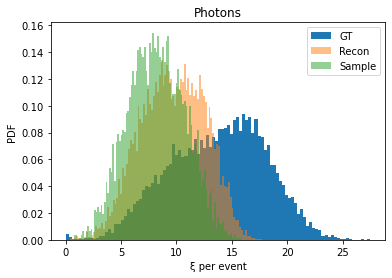

In [186]:
plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=100, density=True)
plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.hist(xihat_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.xlabel("ξ per event")
plt.ylabel("PDF")
plt.legend(["GT", "Recon", "Sample"])
plt.title("Photons")
plt.show()

In [128]:
np.power(2,7)*256

32768

In [ ]:
# GT and Recon Comparison

In [55]:
sampDataAll, sampDataOutAll = np.array([]), np.array([])
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    
    sampDataAll = np.append(sampDataAll, np.sum(in_data.detach().cpu().numpy(), axis=1))
    sampDataOutAll = np.append(sampDataOutAll, np.sum(fwd_output.output_activations.detach().cpu().numpy(), axis=1))

In [61]:
binwidth = 1

plt.hist(sampDataAll, bins=range(int(np.floor(min(sampDataAll))), int(np.ceil(max(sampDataAll))) + binwidth, binwidth), log=True, density=True)
plt.hist(sampDataOutAll, bins=range(int(np.floor(min(sampDataOutAll))), int(np.ceil(max(sampDataOutAll))) + binwidth, binwidth), log=True, density=True, alpha = 0.5)
plt.show()

NameError: name 'sampDataAll' is not defined

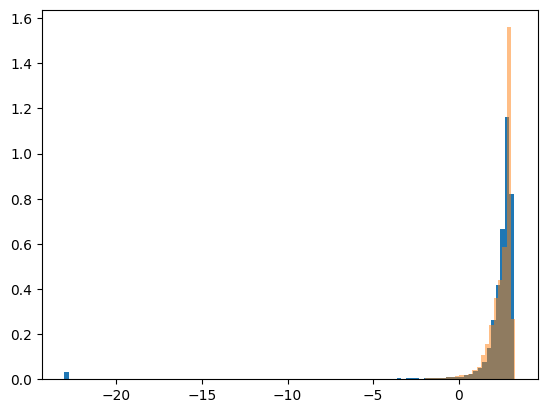

In [57]:
binwidth = 1
plt.hist(np.log(sampDataAll + 1e-10), bins=100, density=True)
plt.hist(np.log(sampDataOutAll + 1e-10), bins=100, density=True, alpha = 0.5)
plt.show()

In [33]:
# model

In [31]:
# model._hit_smoothing_dist_mod #(output_hits, beta, is_training)

In [89]:
seq1 = nn.Sequential(
                   # nn.Linear(self.num_input_nodes, 24*24),
                   # nn.Unflatten(1, (1,24, 24)),
    
                   nn.Conv2d(1, 16, 3, 1, 0),
                   nn.BatchNorm2d(16),
                   nn.PReLU(16, 0.02),
                )
sequential2 = nn.Sequential(
                   nn.Conv2d(17, 32, 3, 1, 0),
                   # nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(32, 0.02),
                   nn.BatchNorm2d(32),
                )

sequential3 = nn.Sequential(
                   nn.Conv2d(33, 64, 3, 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(64, 0.02),
                )

sequential4 = nn.Sequential(
                   nn.Conv2d(65, 128, 3, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(128, 0.02),
                   nn.BatchNorm2d(128),
                   

                   nn.Conv2d(128, 256, 3, 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),
                   

                   nn.Conv2d(256, 512, 2, 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   
    
                   nn.Conv2d(512, 1024, 2, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),

                    nn.Conv2d(1024, 1000, 2, 1, 0),
                   # nn.MaxPool2d(2,stride=2),
                   # nn.PReLU(self.n_latent_nodes, 0.02),
                   nn.Sigmoid(),
                   # nn.BatchNorm2d(self.n_latent_nodes),
    
                   nn.Flatten(),
                )


In [90]:
x = torch.rand(2,1,24,24)
x0 = torch.ones(2,1)*3
minEnergy = 3
x = seq1(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential2(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential3(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential4(x)

x.shape



# tuple(torch.tensor(x.shape[-2:]).tolist())
# tuple([1,2])
# torch.tensor(x.shape[-2:-1]).item()

torch.Size([2, 1000])

In [ ]:
nn.Sequential(
                   nn.Linear(self.num_input_nodes, 24*24),
                   nn.Unflatten(1, (1,24, 24)),
    
                   nn.Conv2d(1, 16, 3, 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(16, 0.02),
                )
        self.sequential2 = nn.Sequential(
                   nn.Conv2d(65, 128, 3, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(128, 0.02),
                   nn.BatchNorm2d(128),
                   

                   nn.Conv2d(128, 256, 3, 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),
                   

                   nn.Conv2d(256, 512, 2, 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   
    
                   nn.Conv2d(512, 1024, 2, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),